**Problem 1: tSNE dim reduction**

part A) Run tSNE library/package on MNIST and 20NG datasets, to obtain a representation is 2-dim or 3-dim, and visualize the data by plotting datapoints with a color per label. Try different values for perplexity like 5, 20 and 100.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups, fetch_openml
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split

This code applies t-SNE dimensionality reduction to visualize two datasets: MNIST (image data) and 20 Newsgroups (text data). For each dataset, the code produces 2-dimensional visualizations using t-SNE, exploring different perplexity values (5, 20, and 100) to illustrate how varying perplexity affects the clarity and structure of the resulting plots. The visualizations are colored according to their labels, highlighting potential clusters or patterns within each dataset.

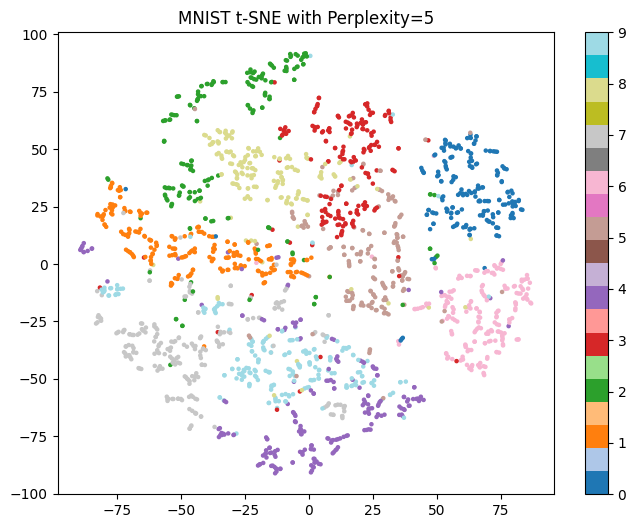

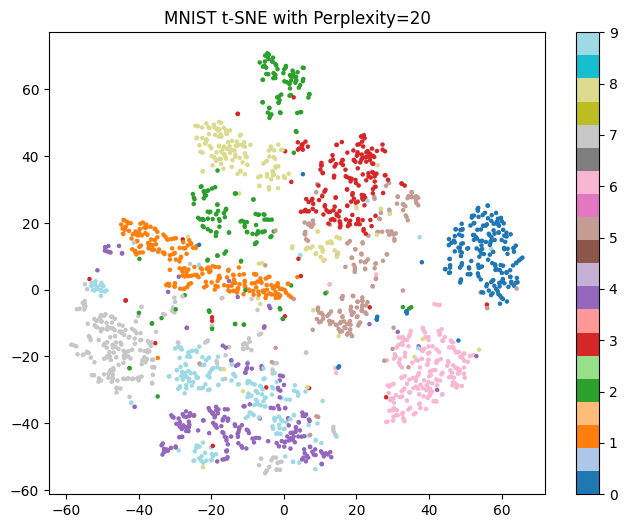

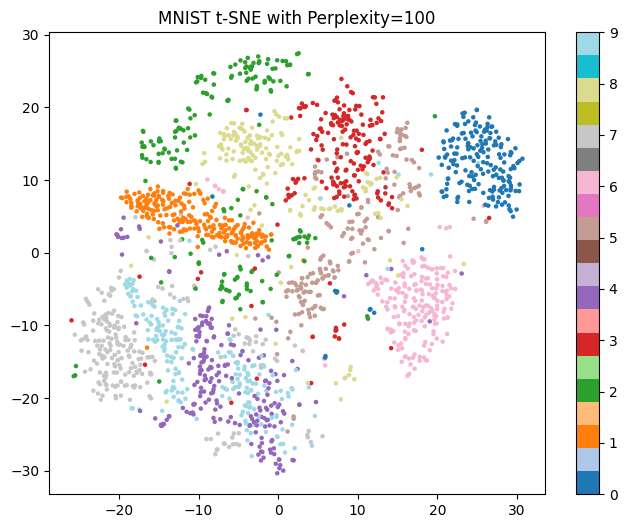

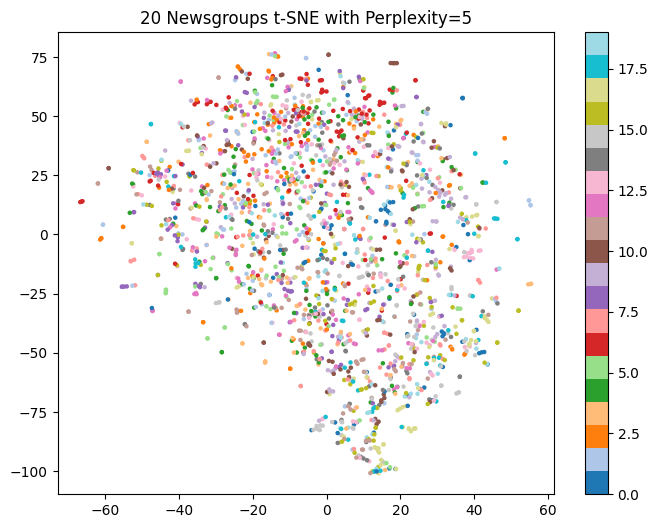

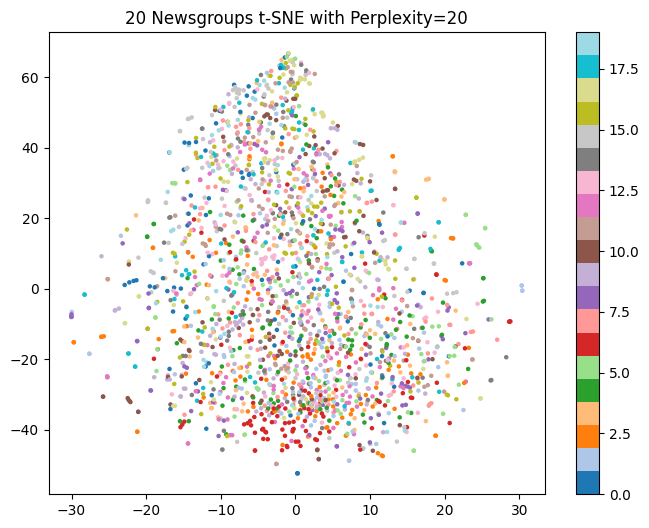

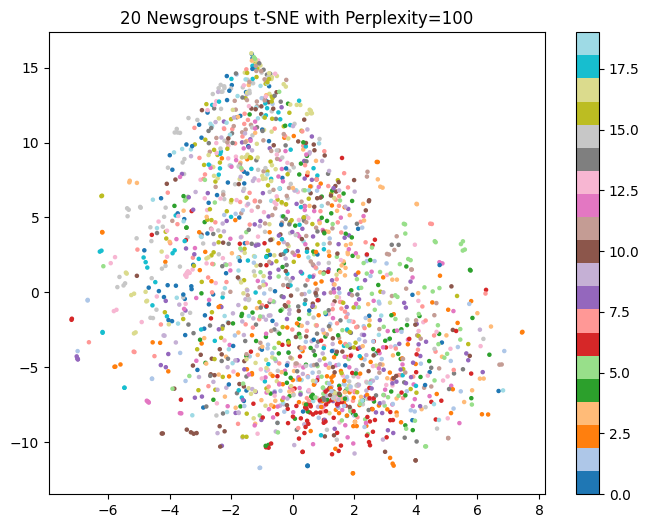

In [ ]:
# MNIST Dataset
mnist = fetch_openml('mnist_784', version=1)
X_mnist = mnist.data[:2000]
y_mnist = mnist.target[:2000].astype(int)

# 20 Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='train')
vectorizer = CountVectorizer(max_features=1000)
X_20ng = vectorizer.fit_transform(newsgroups.data[:2000]).toarray()
y_20ng = newsgroups.target[:2000]

# t-SNE visualization function
def plot_tsne(X, y, dataset_name, perplexities=[5,20,100]):
    for perp in perplexities:
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        X_embedded = tsne.fit_transform(X)
        plt.figure(figsize=(8,6))
        plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y, cmap='tab20', s=5)
        plt.colorbar()
        plt.title(f"{dataset_name} t-SNE with Perplexity={perp}")
        plt.show()

# Plotting tSNE visualizations
plot_tsne(X_mnist, y_mnist, 'MNIST')
plot_tsne(X_20ng, y_20ng, '20 Newsgroups')

part B) Run DBscan on tSNE-MNIST of G=2,3,5 dimensions. This should work much better than DBscan on original MNIST or on PCA-MNIST. You should be able to observe most datapoints "colored" and the colors roughly corresponding to image labels. We got the following confusion matrix with tSNE into 3 dimensions, and some trial-and-error with DBSCAN parameters:

This code applies t-SNE dimensionality reduction followed by DBSCAN clustering on the MNIST dataset. It reduces data dimensions to 2D, 3D, and 5D spaces, applying the appropriate computational method (barnes_hut for lower dimensions and exact for higher). After dimensionality reduction, DBSCAN clusters the embedded points. Finally, it visualizes these clusters using scatter plots (2D or 3D), allowing visual assessment of cluster structure at different embedding dimensions.










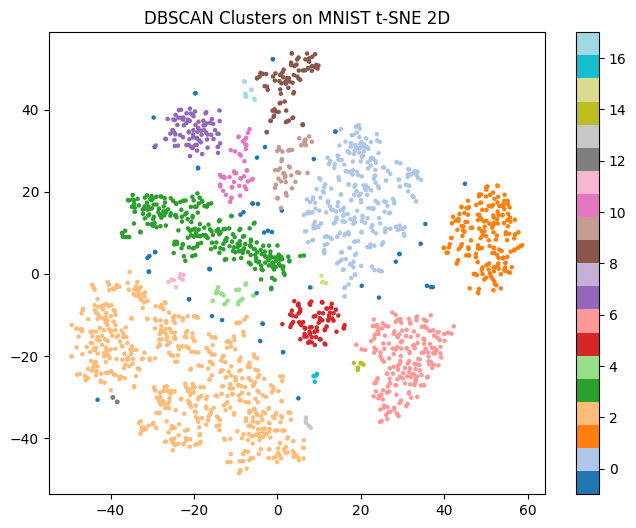

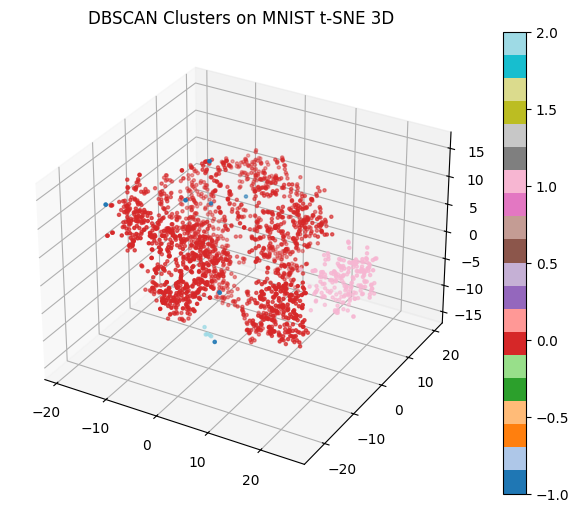

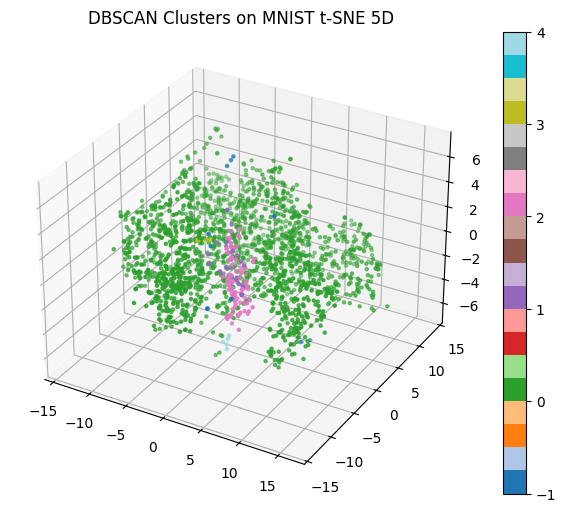

In [ ]:
def run_dbscan_on_tsne(X, y, dims=[2,3,5]):
    for dim in dims:
        # Set method='exact' if dimensions > 3, else use ('barnes_hut')
        method = 'exact' if dim > 3 else 'barnes_hut'

        tsne = TSNE(n_components=dim, perplexity=30, method=method, random_state=42)
        X_embedded = tsne.fit_transform(X)

        clustering = DBSCAN(eps=3, min_samples=5).fit(X_embedded)

        # Visualization
        plt.figure(figsize=(8,6))
        if dim == 2:
            plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.labels_, cmap='tab20', s=5)
            plt.title(f"DBSCAN Clusters on MNIST t-SNE {dim}D")
            plt.colorbar()
            plt.show()
        elif dim >= 3:
            from mpl_toolkits.mplot3d import Axes3D
            ax = plt.axes(projection='3d')
            scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2],
                                 c=clustering.labels_, cmap='tab20', s=5)
            plt.title(f"DBSCAN Clusters on MNIST t-SNE {dim}D")
            plt.colorbar(scatter)
            plt.show()
        else:
            print(f"{dim}D visualization not supported.")

run_dbscan_on_tsne(X_mnist, y_mnist)

**Problem 2: Implement t-SNE dim reduction, run on MNIST Dataset**

This code manually implements the t-SNE algorithm from scratch on the MNIST dataset. First, it loads and preprocesses the dataset (normalizing, mean-centering, and applying PCA for initial dimensionality reduction). Then, it computes pairwise similarity probabilities in the high-dimensional space (captured by matrix P) using binary search to match a target perplexity. It performs iterative optimization through gradient descent, adjusting the positions (y) in a lower-dimensional space (2D) to minimize the divergence between high-dimensional similarities (P) and their low-dimensional counterparts (Q). The code also periodically visualizes the resulting 2D embeddings, showing how clusters representing different digit classes emerge throughout the optimization process.

Iteration 50, error 1.1022


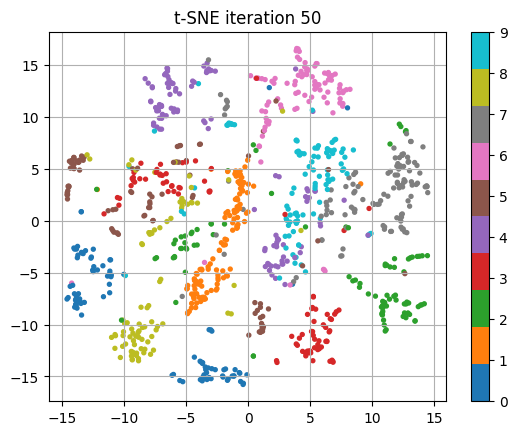

Iteration 100, error 0.9763


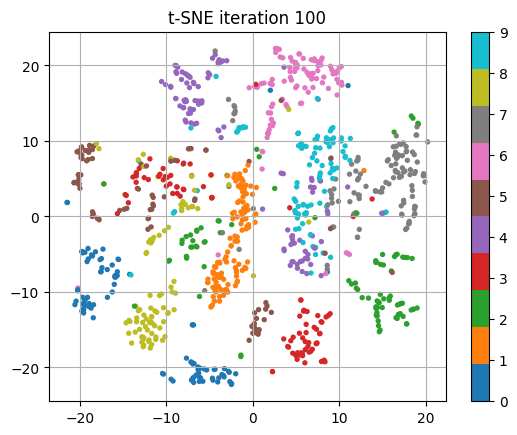

Iteration 150, error 0.8815


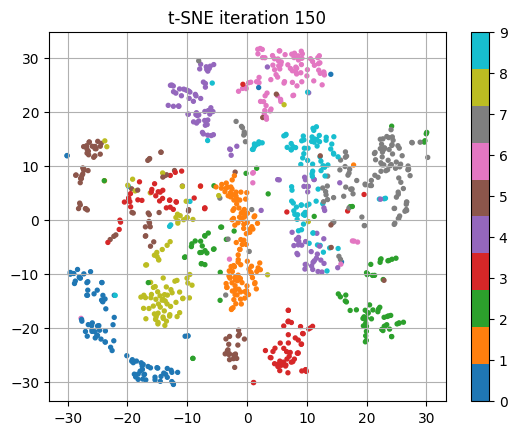

Iteration 200, error 0.8435


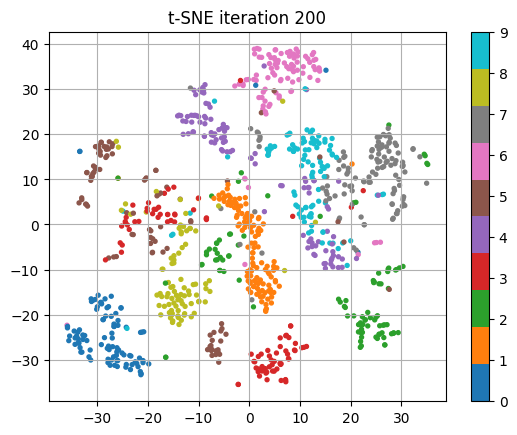

Iteration 250, error 0.8249


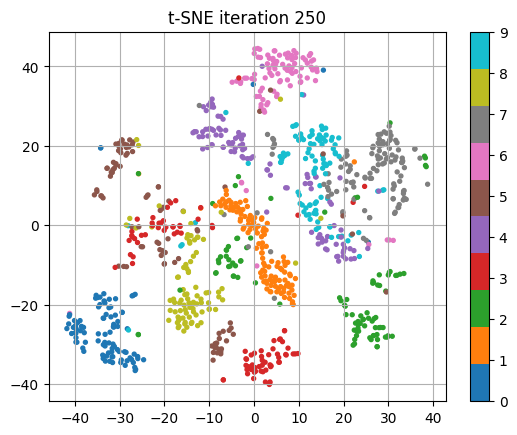

Iteration 300, error 0.8137


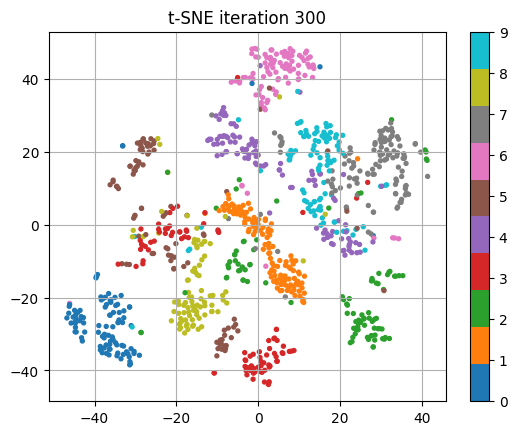

Iteration 350, error 0.8026


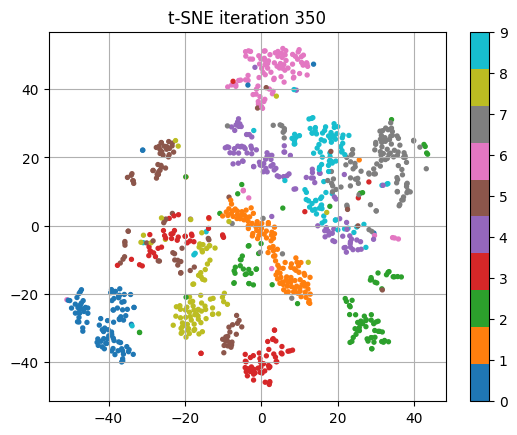

Iteration 400, error 0.7927


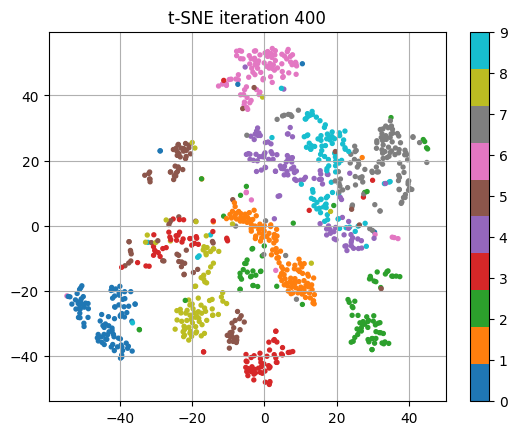

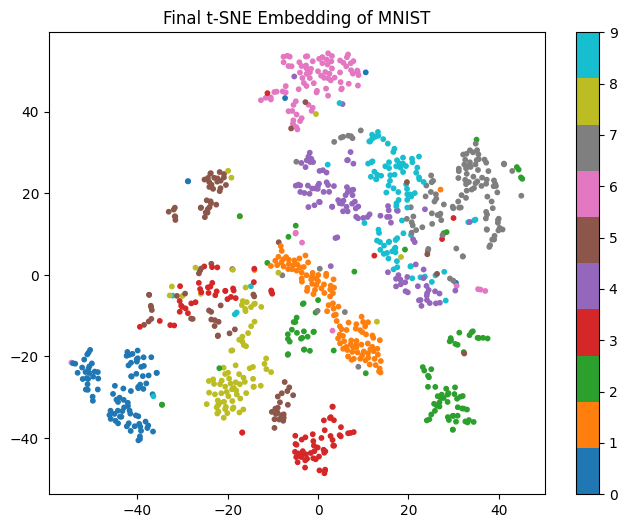

In [ ]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data[:1000].astype(np.float64)
labels = mnist.target[:1000].astype(int)

# Normalize data to 0-1 and mean-zero
X /= 255.0
X -= np.mean(X, axis=0)

# PCA to 50 dimensions
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Compute pairwise distances
D = squareform(pdist(X_pca, 'sqeuclidean'))

# Initialize parameters
N = X_pca.shape[0]
perplexity = 30
tol = 1e-5
max_iter = 400
epsilon = 500
momentum = 0.5
y = np.random.randn(N, 2) * 0.0001
y_incs = np.zeros_like(y)
gains = np.ones_like(y)

# Function to compute entropy and P-row
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    P /= sumP
    H = -np.sum(P * np.log2(P + 1e-10))
    return H, P

# Compute P matrix
P = np.zeros((N, N))
for i in range(N):
    beta = 1.0
    betamin, betamax = -np.inf, np.inf
    Di = np.delete(D[i, :], i)
    H, thisP = Hbeta(Di, beta)
    Hdiff = H - np.log2(perplexity)

    trials = 0
    while np.abs(Hdiff := H - np.log2(perplexity)) > tol and trials < 50:
        if Hdiff > 0:
            betamin = beta
            beta = beta * 2 if betamax == np.inf else (beta + betamax) / 2
        else:
            betamax = beta
            beta = beta / 2 if betamin == -np.inf else (beta + betamin) / 2
        H, thisP = Hbeta(Di, beta)
        trials += 1

    P[i, np.concatenate((np.r_[:i], np.r_[i+1:N]))] = thisP

# Symmetrize and normalize P
P = (P + P.T) / (2 * N)
P = np.maximum(P, 1e-12)

# t-SNE iterations
for iter in range(max_iter):
    sum_y = np.sum(np.square(y), axis=1)
    num = 1 / (1 + np.add.outer(sum_y, sum_y) - 2 * np.dot(y, y.T))
    np.fill_diagonal(num, 0)
    Q = num / np.sum(num)
    Q = np.maximum(Q, 1e-12)

    # Gradient computation
    PQ = P - Q
    grads = 4 * (np.diag(np.sum(PQ * num, axis=1)) - PQ * num).dot(y)

    # Update gains and increments
    gains = (gains + 0.2) * ((grads > 0) != (y_incs > 0)) + (gains * 0.8) * ((grads > 0) == (y_incs > 0))
    gains[gains < 0.01] = 0.01
    y_incs = momentum * y_incs - epsilon * (gains * grads)
    y += y_incs

    # Adjust momentum after some iterations
    if iter == 100:
        momentum = 0.8

    # Center the map
    y -= np.mean(y, axis=0)

    # Visualization every 50 iterations
    if (iter + 1) % 50 == 0:
        C = np.sum(P * np.log(P / Q))
        print(f"Iteration {iter+1}, error {C:.4f}")
        plt.scatter(y[:,0], y[:,1], c=labels, cmap='tab10', s=8)
        plt.title(f't-SNE iteration {iter+1}')
        plt.colorbar()
        plt.grid(True)
        plt.show()

# Final visualization
plt.figure(figsize=(8,6))
plt.scatter(y[:,0], y[:,1], c=labels, cmap='tab10', s=10)
plt.title('Final t-SNE Embedding of MNIST')
plt.colorbar()
plt.show()

**Problem 3: Pairwise Feature selection for text**

On 20NG, run feature selection using skikit-learn built in "chi2" criteria to select top 200 features. Rerun a classification task, compare performance with HW3A-PB1. Then repeat the whole pipeline with "mutual-information" criteria.

This code performs feature selection and classification on the "20 Newsgroups" text dataset. It first converts raw text into numerical features (word counts). Then it splits the dataset into training and testing subsets. Feature selection is performed separately using two methods: Chi-Squared (chi2) and Mutual Information (mutual_info), selecting the top 200 most relevant features each time. After selecting features, a Logistic Regression classifier is trained on the reduced feature set. Finally, the classifier is evaluated on the test set, printing detailed classification performance reports for each of the two feature selection methods.

In [ ]:
# loading 20NG data
newsgroups = fetch_20newsgroups(subset='train')
vectorizer = CountVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(newsgroups.data[:2000]).toarray()
y_text = newsgroups.target[:2000]

def feature_selection_and_classification(X, y, method='chi2'):
    # split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)

    # feature selection using training data
    selector = SelectKBest(score_func=chi2 if method=='chi2' else mutual_info_classif, k=200)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # train classifier on selected features
    clf = LogisticRegression(max_iter=2000, solver='lbfgs')
    clf.fit(X_train_selected, y_train)

    # predict on test data and print report
    y_pred = clf.predict(X_test_selected)
    print(f"Classification Report using {method} feature selection (Test set):")
    print(classification_report(y_test, y_pred))

feature_selection_and_classification(X_text, y_text, method='chi2')
feature_selection_and_classification(X_text, y_text, method='mutual_info')

Classification Report using chi2 feature selection (Test set):
              precision    recall  f1-score   support

           0       0.35      0.32      0.33        25
           1       0.32      0.38      0.35        24
           2       0.47      0.50      0.48        30
           3       0.53      0.39      0.45        23
           4       0.49      0.54      0.51        37
           5       0.50      0.73      0.59        30
           6       0.70      0.51      0.59        37
           7       0.60      0.58      0.59        31
           8       0.61      0.47      0.53        30
           9       0.49      0.63      0.55        30
          10       0.66      0.59      0.62        32
          11       0.71      0.75      0.73        32
          12       0.26      0.34      0.30        35
          13       0.52      0.47      0.49        34
          14       0.68      0.62      0.65        21
          15       0.62      0.49      0.55        43
          16      

**Problem 4: L1 feature selection on text**

Run a strongL1-regularized regression (library) on 20NG, and select 200 features (words) based on regression coefficients absolute value. Then reconstruct the dateaset with only these features, and rerun any of the classification tasks,

This code performs feature selection on the "20 Newsgroups" text dataset using L1-regularized logistic regression. Initially, the dataset is split into training and testing subsets. It then fits a logistic regression model with L1 regularization, which inherently shrinks less relevant features toward zero. Features are ranked based on the magnitude of their coefficients, and the top 200 most important features are selected. A new logistic regression classifier is trained using only these selected features, and its performance is evaluated on the test set, displaying a detailed classification report.










In [ ]:
# loading 20NG data
newsgroups = fetch_20newsgroups(subset='train')
vectorizer = CountVectorizer(max_features=1000)
X_text = vectorizer.fit_transform(newsgroups.data[:2000]).toarray()
y_text = newsgroups.target[:2000]

def l1_feature_selection(X, y, top_features=200):
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # Fit L1-regularized logistic regression
    clf = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000)
    clf.fit(X_train, y_train)

    # Select top features based on absolute coefficient magnitudes
    importance = np.abs(clf.coef_).sum(axis=0)
    top_feature_indices = np.argsort(importance)[-top_features:]

    # Reconstruct dataset using selected features
    X_train_selected = X_train[:, top_feature_indices]
    X_test_selected = X_test[:, top_feature_indices]

    # Retrain and evaluate classifier on selected features
    clf_selected = LogisticRegression(max_iter=2000, solver='lbfgs')
    clf_selected.fit(X_train_selected, y_train)
    y_pred = clf_selected.predict(X_test_selected)

    # Print classification report
    print("Classification report after L1 feature selection (test set):")
    print(classification_report(y_test, y_pred))

l1_feature_selection(X_text, y_text)

Classification report after L1 feature selection (test set):
              precision    recall  f1-score   support

           0       0.42      0.44      0.43        25
           1       0.37      0.42      0.39        24
           2       0.39      0.50      0.44        30
           3       0.18      0.13      0.15        23
           4       0.33      0.35      0.34        37
           5       0.36      0.40      0.38        30
           6       0.60      0.57      0.58        37
           7       0.43      0.39      0.41        31
           8       0.61      0.57      0.59        30
           9       0.44      0.50      0.47        30
          10       0.53      0.59      0.56        32
          11       0.69      0.62      0.66        32
          12       0.31      0.34      0.32        35
          13       0.40      0.41      0.41        34
          14       0.45      0.48      0.47        21
          15       0.57      0.58      0.57        43
          16       0